
## Computation of Aggressiveness Index for CARLA autopilot following FTP-75 cycle.
Recalling that the index is define as follows:
$AggIn=\frac{avg(ESD(TP(t)))}{std(v_{desired}(t)-v_{real}(t))}$

Energy Spectral Density for descrete signal is given by $\bar{S}_{x x}(f)=\lim _{N \rightarrow \infty}(\Delta t)^2\left|\sum_{n=-N}^N x_n e^{-i 2 \pi f n \Delta t}\right|^2$

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import scipy.signal as sgn

In [22]:
def esd(yt, fs):
    # computes ESD of a signal yt, keeping only positive frequencies! -> NOTE: this implies that total energy is halved
    N = len(yt)
    f = fft.rfftfreq(N, 1/fs)
    Sxx = np.square(1 / fs) *  np.square(np.abs(fft.rfft(yt)))
    
    return f, Sxx

#### Bode plot of PID controller

In [23]:
def bode_plot(kp, ki, kd):
    num = [kd, kp, ki]
    den = [1, 0]
    sys = sgn.TransferFunction(num, den)
    w, mag, phase = sgn.bode(sys)
    plt.figure(figsize=(12,3))
    plt.title('Bode magnitude plot')
    plt.xlabel('Frequency [Hz]')
    plt.semilogx(w, mag)
    plt.figure(figsize=(12,3))
    plt.title('Bode phase plot')
    plt.xlabel('Frequency [Hz]')
    plt.semilogx(w, phase)
    plt.show()

The controller for longitudinal motion on CARLA's autopilot is the following PI controller:  $G(s)=0.05\cdot\frac{1+20s}{s}$

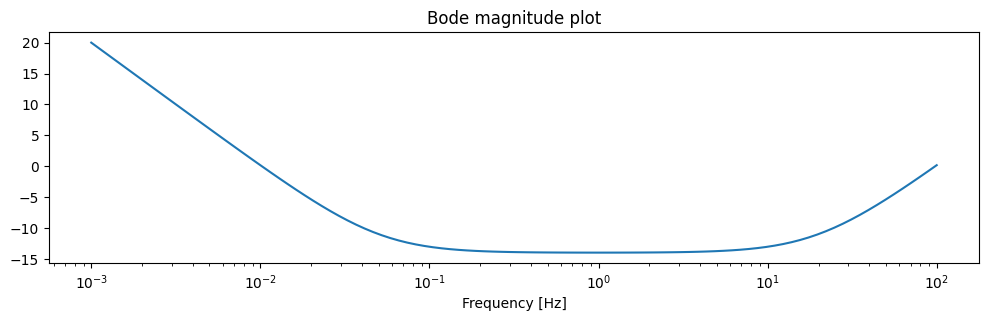

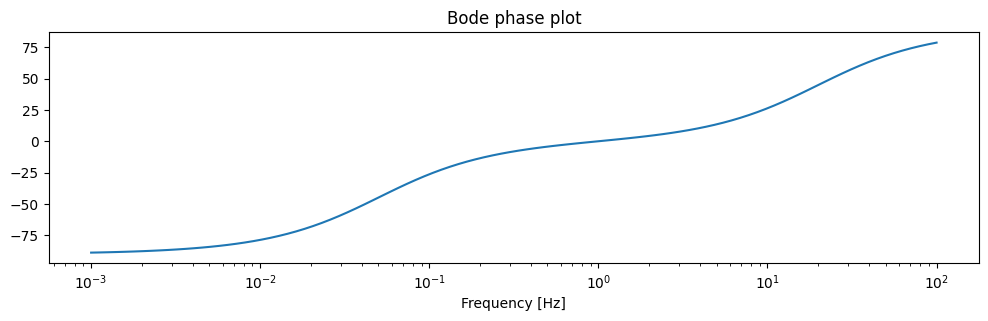

In [34]:
bode_plot(0.2, 0.01, 0.01)

#### Import data retrieved by ```FTP_follower.ipynb```

In [63]:
filename = 'collectedData_slowAgent/FTPfollowing_slowAgent_fUpdate=10Hz_PID=(0.08,0.01,0.01)_dt=0.005.csv'
dt = 0.005

signals_df = pd.read_csv(filename, sep=',', header=0)
x_t = np.array(signals_df['Time'], dtype=float)
y_rv = np.array(signals_df['Velocity'], dtype=float)
y_tv = np.array(signals_df['Target Velocity'], dtype=float)
y_tp = np.array(signals_df['Throttle'], dtype=float)
y_bp = np.array(signals_df['Brake'], dtype=float)

In [64]:
# Limit parameters for plotting
x_a = 0         # default
x_b = x_t[-1]   # default


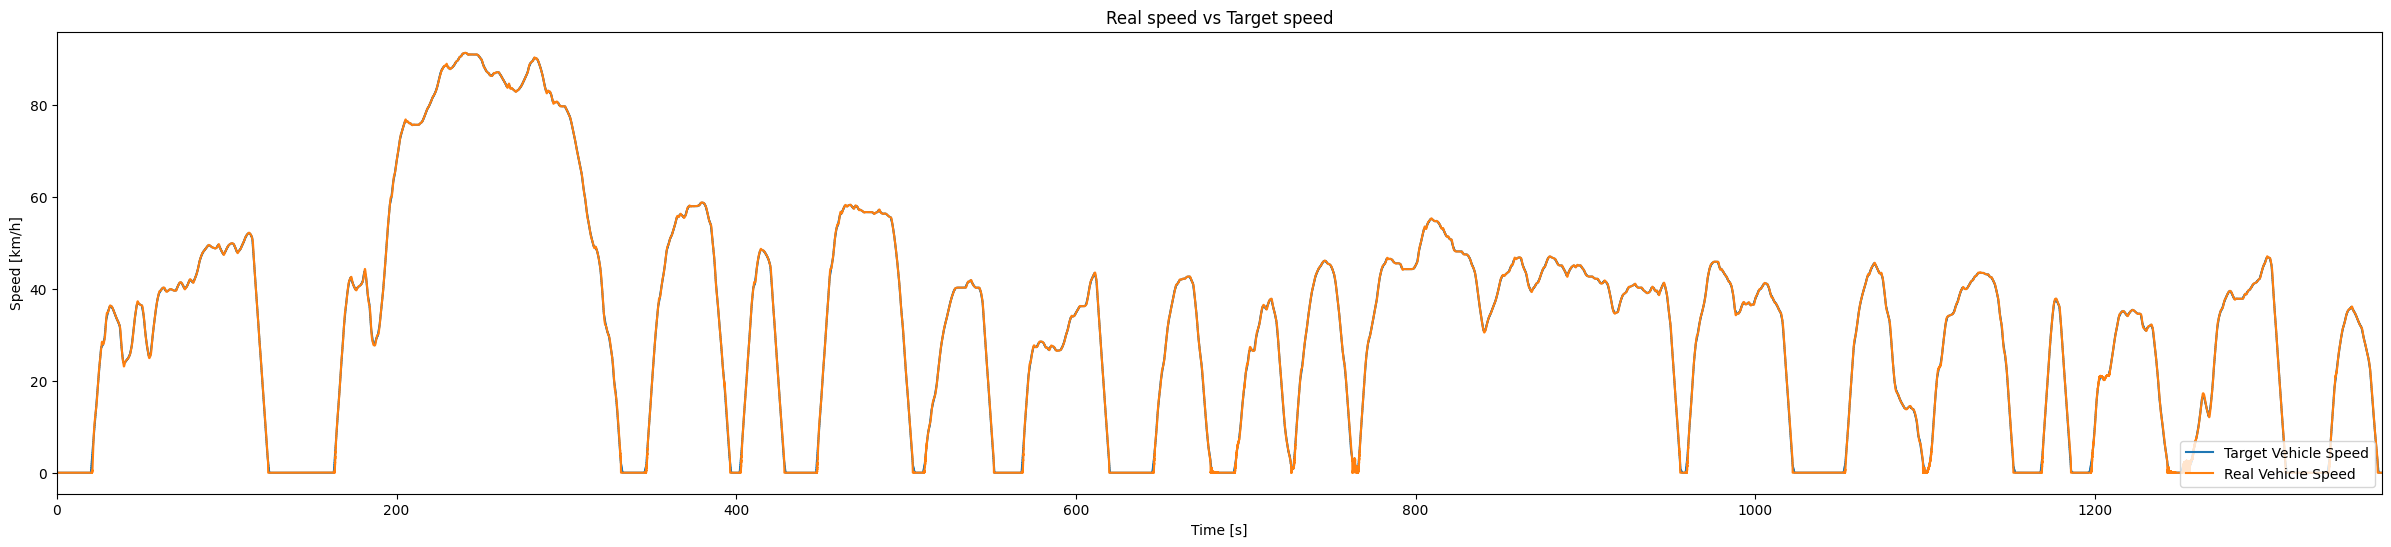

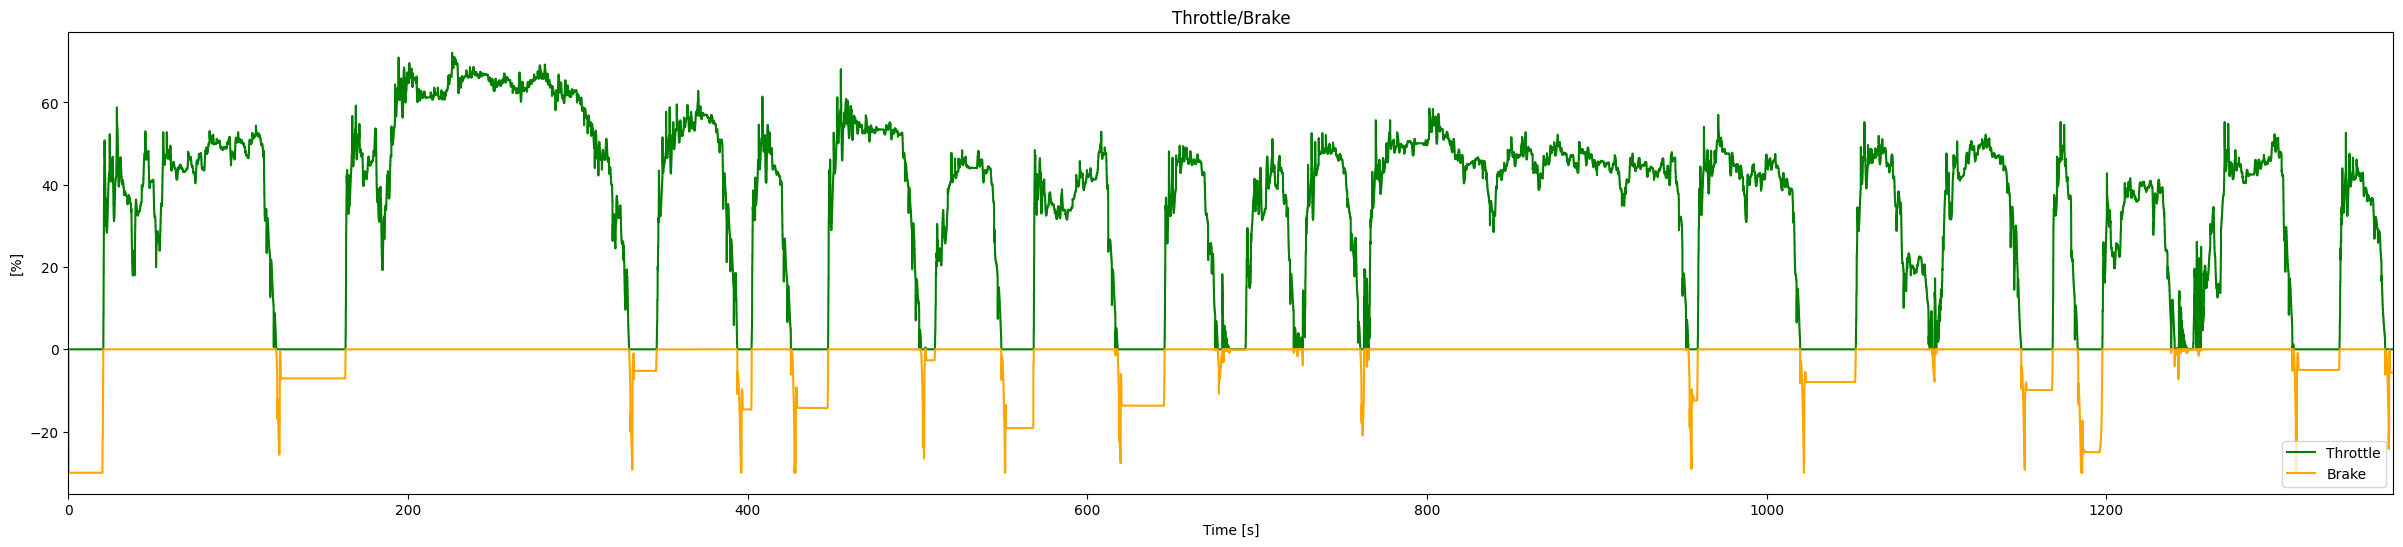

In [65]:
plt.figure(figsize=(30,6))
plt.title("Real speed vs Target speed")
plt.ylabel("Speed [km/h]")
plt.xlabel("Time [s]")
plt.xlim(x_a, x_b)
plt.plot(x_t, y_tv, label='Target Vehicle Speed')
plt.plot(x_t, y_rv, label='Real Vehicle Speed')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(30,6))
plt.title("Throttle/Brake")
plt.ylabel("[%]")
plt.xlabel("Time [s]")
plt.xlim(x_a, x_b)
plt.plot(x_t, 100 * y_tp, label='Throttle', color='green')
plt.plot(x_t, -100 * y_bp, label='Brake', color='orange')
plt.legend(loc="lower right")
plt.show()

#### DTFT of throttle signal

In [66]:
# Subsample data to 10 Hz
fs_FTP = 10
k_subsample = int(1 / (dt * fs_FTP))

x_t = x_t[::k_subsample]
y_rv = y_rv[::k_subsample]
y_tv = y_tv[::k_subsample]
y_tp = y_tp[::k_subsample]
y_bp = y_bp[::k_subsample]

dt = 1 / fs_FTP
fs = fs_FTP

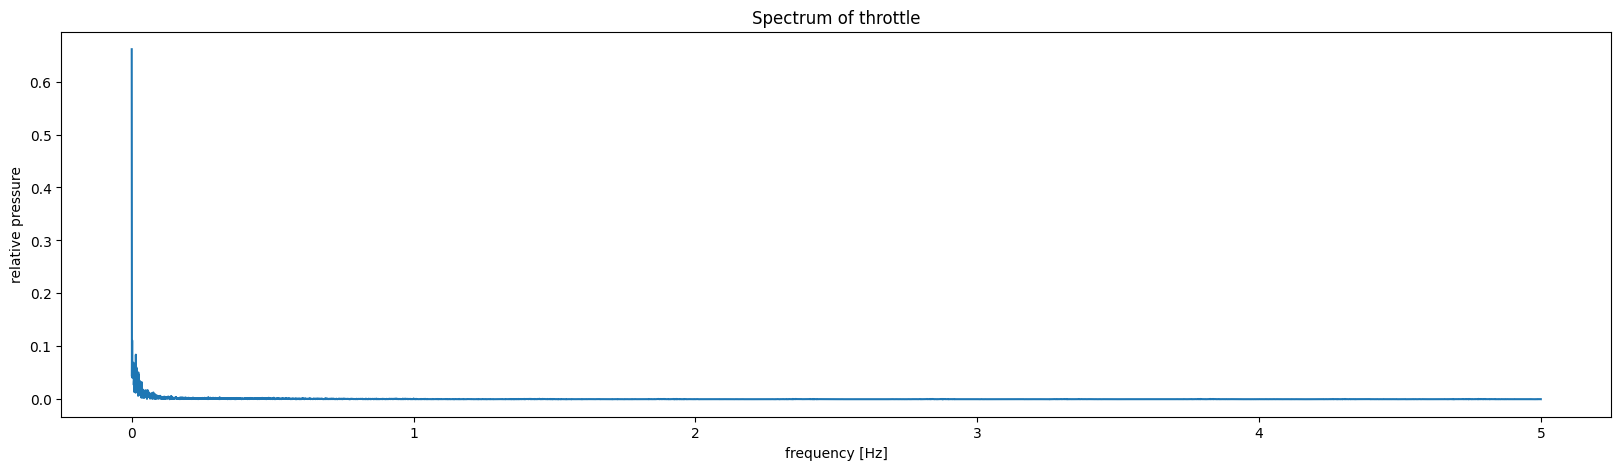

In [67]:
duration = x_t[-1] - x_t[0]
N = len(y_tv)
yf = fft.rfft(y_tp)
xf = fft.rfftfreq(N, 1/fs)

plt.figure(figsize=(20,5))
# plt.xlim(0, 100)
# plt.ylim(0,0.01)
plt.title("Spectrum of throttle")
plt.xlabel("frequency [Hz]")
plt.ylabel("relative pressure")
plt.plot(xf, np.abs(yf) * 2 / (fs * duration))
plt.show()

## Index computation

##### Average ESD

In [68]:
# convert the signal amplitude from percentage to angle of pressure assuming a linear relationship
# y_tp = 90 * y_tp

f, Sxx = esd(y_tp, fs)
mean_esd = np.mean(Sxx)
print("Mean ESD: ", mean_esd)

Mean ESD:  36.11150999722014


##### Standard deviation of the tracking error

In [69]:
# tracking error
e = y_tv - y_rv
np.std(e)

0.3376019971202959

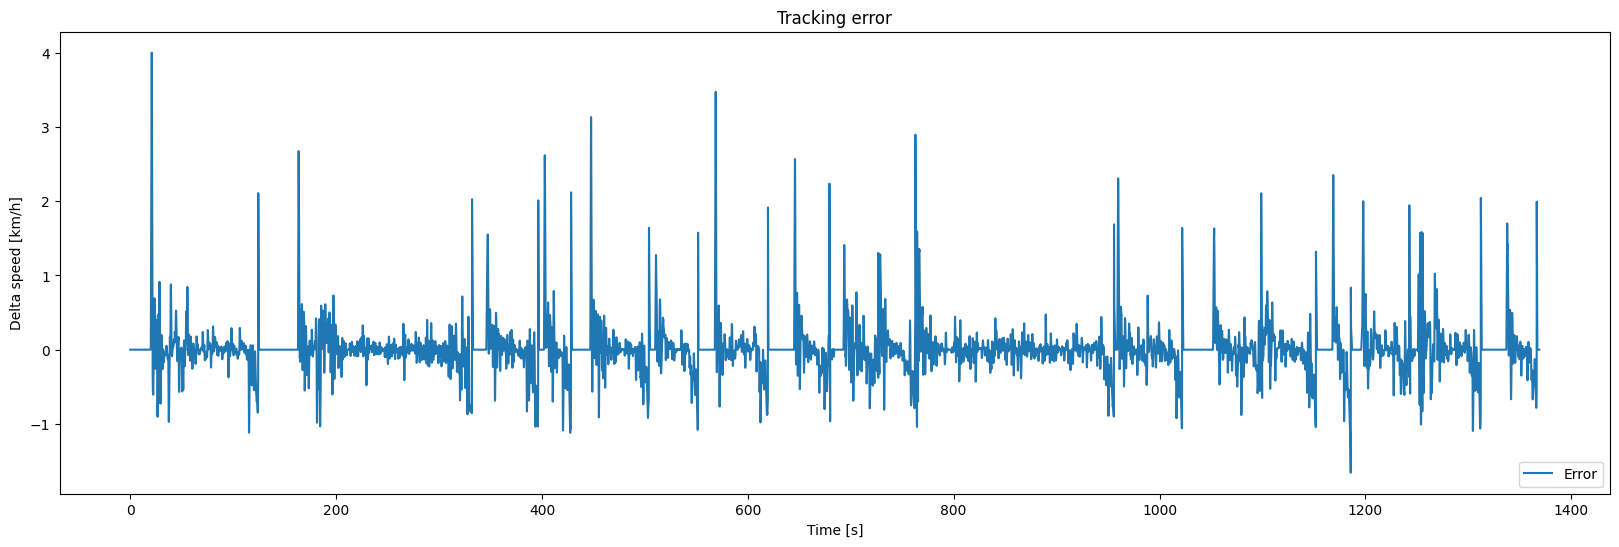

In [70]:
plt.figure(figsize=(20,6))
plt.title("Tracking error")
plt.ylabel("Delta speed [km/h]")
plt.xlabel("Time [s]")
# plt.xlim(50,100)
plt.plot(x_t, e, label='Error')
plt.legend(loc="lower right")
plt.show()

##### Final index

In [71]:
print("Aggressiveness index: ", mean_esd / np.std(e))

Aggressiveness index:  106.96474044954395
